In [3]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import pylops #
# from scipy import stats
# from scipy.stats import pearsonr as pearson
import helper_functions as hf
from tqdm import tqdm
# from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [4]:
# Usando o Volve
filename = "data/volve.sgy"

# Caso tenha o dado de ABL, descomentar a linha abaixo
#filename = "D:/Dados ABL/ABL_FULL_TIME_3D.sgy"
#filename = "C:/Users/aalbano/Desktop/Dados/ABL_FULL_TIME_3D.sgy"
#filename = "C:/Users/aalbano/Desktop/Dados/ABL_FULL_DECON_TIME.sgy"

if filename == "data/volve.sgy":
    ILINE = 30 # 500 - ABL
    XLINE = 101 # 1000 - VOLVE
else:
    ILINE = 500
    XLINE = 1000

In [5]:
f = segyio.open(filename, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

t = f.samples
il = f.attributes(189)[:]
xl = f.attributes(193)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

nil, nxl, nt = len(ilines), len(xlines), len(t)

IndexError: index 1400 is out of bounds for axis 2 with size 850

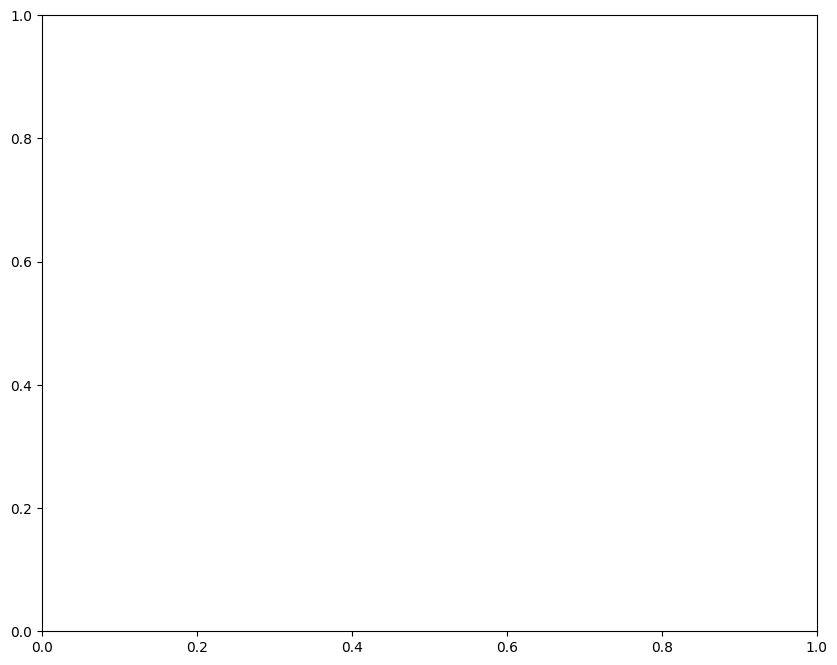

In [6]:
#plotting data
fig, ax = plt.subplots(figsize=(10, 8))


c=ax.imshow(d[500 - il_min: 2220 - il_min, 1500 - xl_min : 2800 - xl_min, 1400], aspect='auto', cmap='gray_r', vmin=-200000, vmax=200000,
            extent=[1500, 2800, 500, 2200])

plt.colorbar(c, ax=ax, pad=0.01)
plt.grid(False)

In [7]:
#d = d[500 - il_min: 2220 - il_min, 1500 - xl_min : 2800 - xl_min, :]

Text(0.5, 1.0, 'Traço sísmico iline 30 e xline 101')

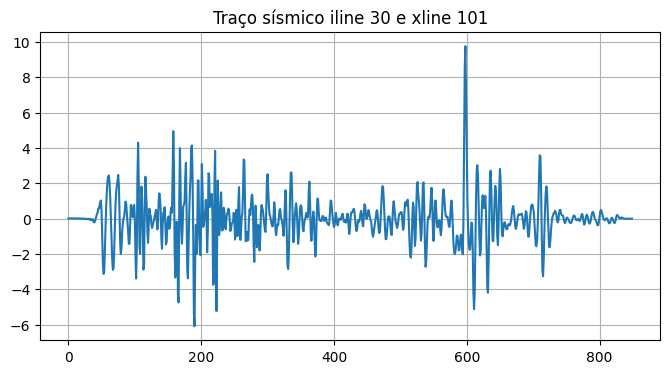

In [8]:
plt.figure(figsize=(8,4))
plt.plot(d[ILINE, XLINE, :])
plt.grid()
plt.title("Traço sísmico iline 30 e xline 101")

In [9]:
d.shape

(61, 202, 850)

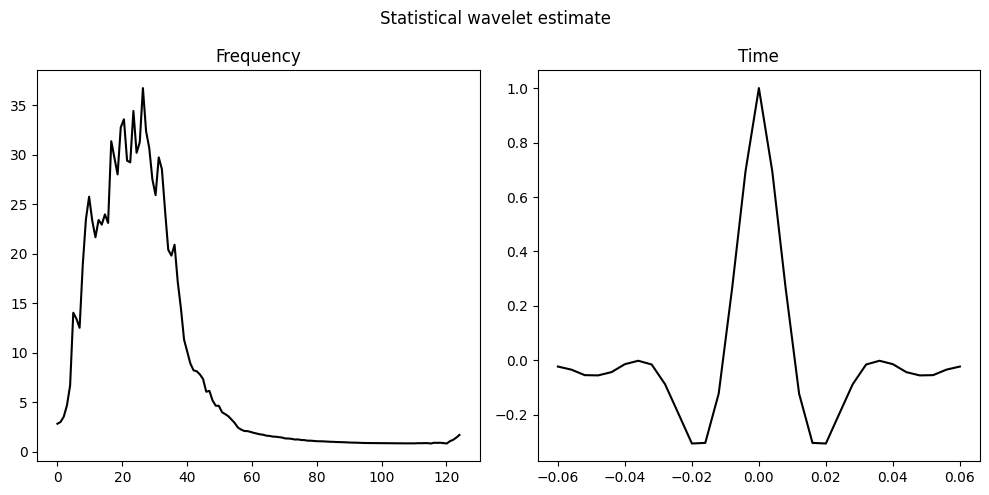

In [10]:
def estimate_wavelet(d, dt):
    """
    Estimate the wavelet from seismic data.

    Parameters:
    d (np.ndarray): The seismic data array.
    dt (float): The sampling interval in milliseconds.

    Returns:
    tuple: A tuple containing the wavelet time axis, estimated wavelet, and wavelet spectrum.
    """
    # Wavelet time axis
    t_wav = np.arange(16) * (dt / 1000)
    t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

    # Estimate wavelet spectrum
    wav_est_fft = np.mean(np.abs(np.fft.fft(d[::2, ::2, int(2500 // dt):int(3500 // dt)], 2**8, axis=-1)), axis=(0, 1))
    fwest = np.fft.fftfreq(2**8, d=dt / 1000)

    # Create wavelet in time
    wav_est = np.real(np.fft.ifft(wav_est_fft)[:16])
    wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
    wav_est = wav_est / wav_est.max()

    return t_wav, wav_est, fwest, wav_est_fft

# Call the function
t_wav, wav_est, fwest, wav_est_fft = estimate_wavelet(d, dt)

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:2**8//2], wav_est_fft[:2**8//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');
plt.tight_layout()

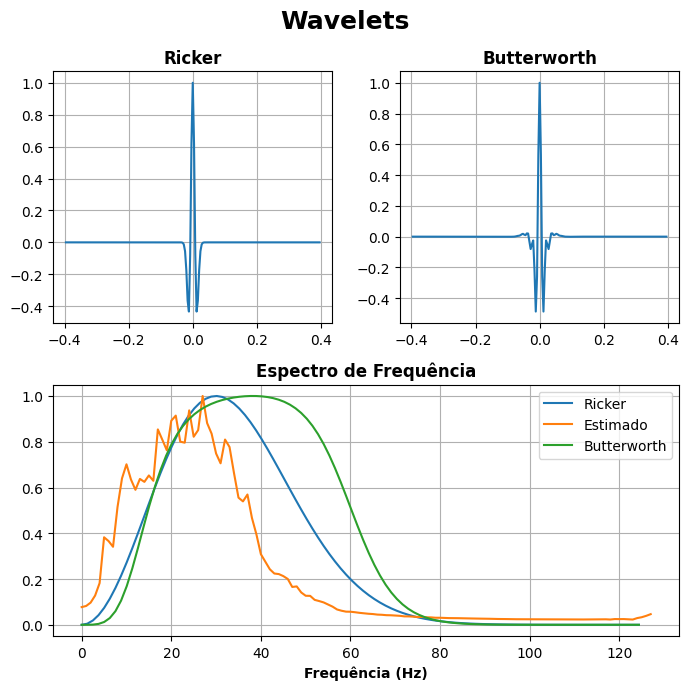

In [11]:
sample = 100
dt = 4
pkfq = 30
highfq = 60
lowfq = 15

twlet, wlet, freqs, fft = hf.generate_ricker(peak_freq=pkfq, samples=sample, dt=dt)
twlet_b, wlet_b, freqs_b, fft_b = hf.generate_butter(
    freq_hi=highfq, freq_low=lowfq, samples=sample, dt=dt
)

plt.figure(figsize=(7, 7))

plt.suptitle("Wavelets", fontsize=18, fontweight="bold")

plt.subplot2grid((2, 2), (0, 0))
plt.plot(twlet, wlet)
plt.tick_params(axis="both")
plt.title("Ricker", fontweight="bold")
plt.grid()

plt.subplot2grid((2, 2), (0, 1))
plt.plot(twlet_b, wlet_b)
plt.tick_params(axis="both")
plt.title("Butterworth", fontweight="bold")
plt.grid()

teste = wav_est_fft[:2**8//2]

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.tick_params(axis="both")
plt.plot(freqs, fft, label="Ricker")
plt.plot(teste / np.max(teste), label="Estimado")
plt.title(
    "Espectro de Frequência", fontweight="bold"
)
plt.plot(freqs_b, fft_b, label="Butterworth")
plt.xlabel("Frequência (Hz)", fontweight="bold")
plt.legend(loc="upper right")
plt.grid()

plt.tight_layout()
plt.show()

In [12]:
nx, ny, nz = d.shape
print(nx, ny, nz)

61 202 850


In [13]:
d_inv2_ppop = pylops.avo.poststack.PoststackLinearModelling(
    wav_est / 2, nt0=nz, spatdims=1, explicit=False
)
d_inv2_ppop_ricker = pylops.avo.poststack.PoststackLinearModelling(
    wlet / 2, nt0=nz, spatdims=1, explicit=False
)
d_inv2_ppop_butter = pylops.avo.poststack.PoststackLinearModelling(
    wlet_b / 2, nt0=nz, spatdims=1, explicit=False
)

In [14]:
epsRs = np.arange(0.1, 1, 0.1)

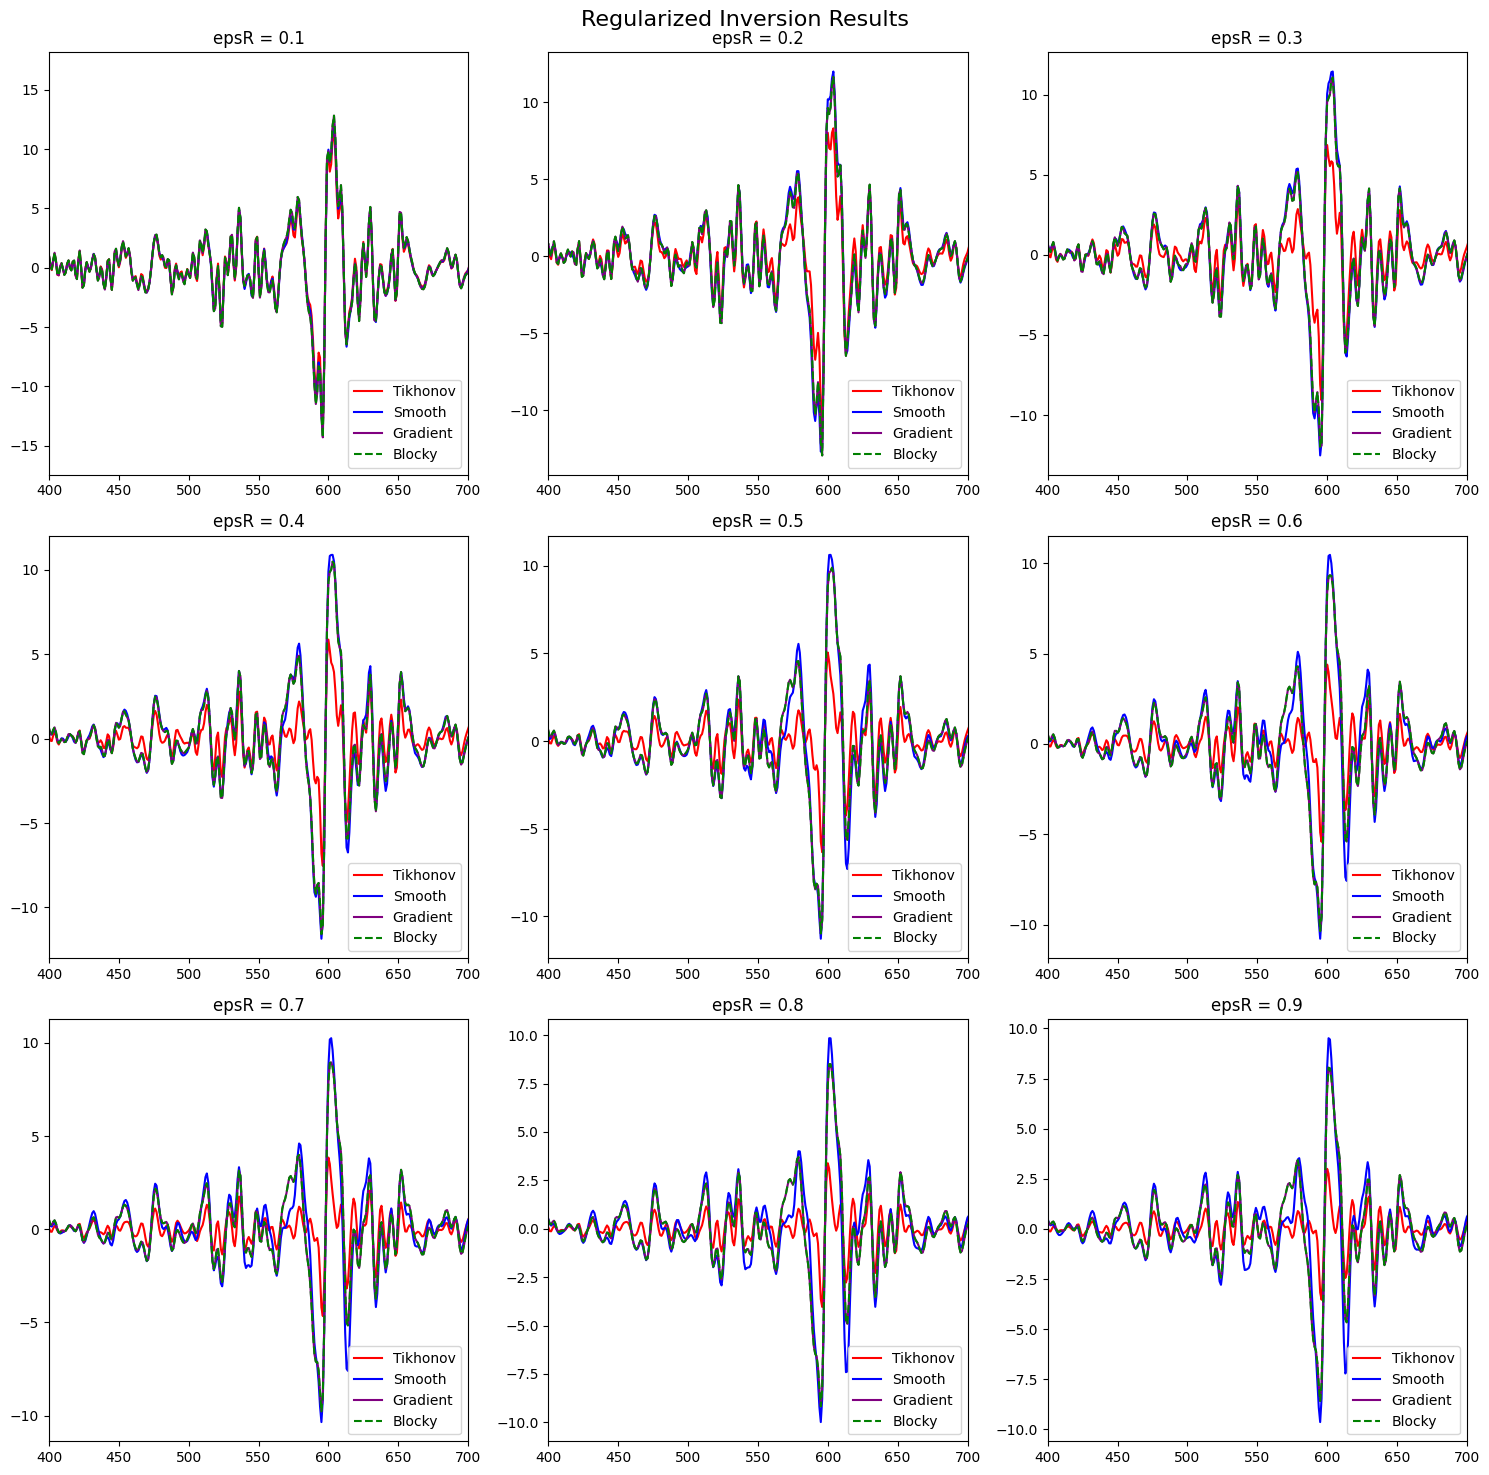

In [33]:
# Initialize lists to store results
tikho_results = []
smooth_results = []
blocky_results = []
gradient_results = []

# Perform regularized inversion for each epsilon value
for i in epsRs:
    d_inv2_tikho = (
        pylops.regularized_inversion(
            Op=d_inv2_ppop,
            y=d[ILINE, XLINE, :],
            Regs=[pylops.Identity(nz)],
            epsRs=[i],
            x0=np.zeros(d[ILINE, XLINE, :].shape),
            engine="pylops",
            #**dict(iter_lim=1000)
        )[0]
    )
    tikho_results.append(d_inv2_tikho)

    d2op = pylops.SecondDerivative(nz)
    d_inv2_smooth = (
        pylops.regularized_inversion(
            Op=d_inv2_ppop,
            y=d[ILINE, XLINE, :],
            Regs=[d2op],
            epsRs=[i],
            x0=np.zeros(d[ILINE, XLINE, :].shape),
            engine="pylops",
            #**dict(iter_lim=1000)
        )[0]
    )
    smooth_results.append(d_inv2_smooth)

    d2op = pylops.FirstDerivative(nz)
    d_inv2_blocky = (
        pylops.regularized_inversion(
            Op=d_inv2_ppop,
            y=d[ILINE, XLINE, :],
            Regs=[d2op],
            epsRs=[i],
            x0=np.zeros(d[ILINE, XLINE, :].shape),
            engine="pylops",
            #**dict(iter_lim=1000)
        )[0]
    )
    blocky_results.append(d_inv2_blocky)
    
    d2op = pylops.Gradient(nz)
    d_inv2_gradient = (
        pylops.regularized_inversion(
            Op=d_inv2_ppop,
            y=d[ILINE, XLINE, :],
            Regs=[d2op],
            epsRs=[i],
            x0=np.zeros(d[ILINE, XLINE, :].shape),
            engine="pylops",
            #**dict(iter_lim=1000)
        )[0]
    )
    gradient_results.append(d_inv2_gradient)

# Plot the results
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Regularized Inversion Results', fontsize=16)

for idx, (tikho, smooth, blocky, gradient) in enumerate(zip(tikho_results, smooth_results, blocky_results, gradient_results)):
    row = idx // 3
    col = idx % 3
    axs[row, col].plot(tikho, '-', color='red', label="Tikhonov")
    axs[row, col].plot(smooth, '-', color='blue', label="Smooth")
    axs[row, col].plot(gradient, '-', color='purple', label="Gradient")
    axs[row, col].plot(blocky, '--', color='green', label="Blocky")
    axs[row, col].set_xlim(400, 700)
    axs[row, col].legend(loc="lower right")
    axs[row, col].set_title(f'epsR = {epsRs[idx]:.1f}')

plt.tight_layout()
#plt.savefig("./figures/regularized_inversion_epsr_decon.png", dpi=400, bbox_inches="tight")
plt.show()

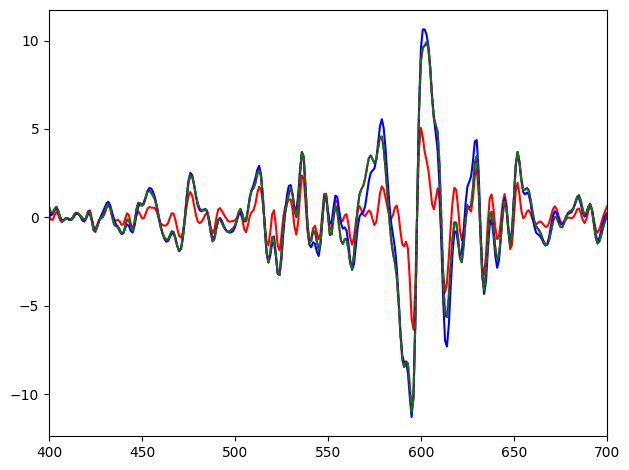

In [30]:
d_inv2_tikho = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[ILINE, XLINE, :],
        Regs=[pylops.Identity(nz)],
        epsRs=[0.5],
        x0=np.zeros(d[ILINE, XLINE, :].shape),
        engine="pylops",
        #**dict(iter_lim=1000)
    )[0]
)

d2op = pylops.SecondDerivative(nz)

d_inv2_smooth = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[ILINE, XLINE, :],
        Regs=[d2op],
        epsRs=[0.5],
        x0=np.zeros(d[ILINE, XLINE, :].shape),
        engine="pylops",
        #**dict(iter_lim=1000)
    )[0]
)

d2op = pylops.FirstDerivative(nz)

d_inv2_blocky = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[ILINE, XLINE, :],
        Regs=[d2op],
        epsRs=[0.5],
        x0=np.zeros(d[ILINE, XLINE, :].shape),
        engine="pylops",
        #**dict(iter_lim=1000)
    )[0]
)

d2op = pylops.Gradient(nz)

d_inv2_gradient = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[ILINE, XLINE, :],
        Regs=[d2op],
        epsRs=[0.5],
        x0=np.zeros(d[ILINE, XLINE, :].shape),
        engine="pylops",
        #**dict(iter_lim=1000)
    )[0]
)

plt.plot(d_inv2_tikho, '-', color='red', label="Tikhonov")
plt.plot(d_inv2_smooth, '-', color='blue', label="Smooth")
plt.plot(d_inv2_gradient, '-', color='purple', label="Gradient")
plt.plot(d_inv2_blocky, '--', color='green', label="Blocky")

plt.xlim(400, 700)
plt.tight_layout()
plt.show()

In [15]:
epsRs_2 = np.array([0.1, 0.5, 0.9])

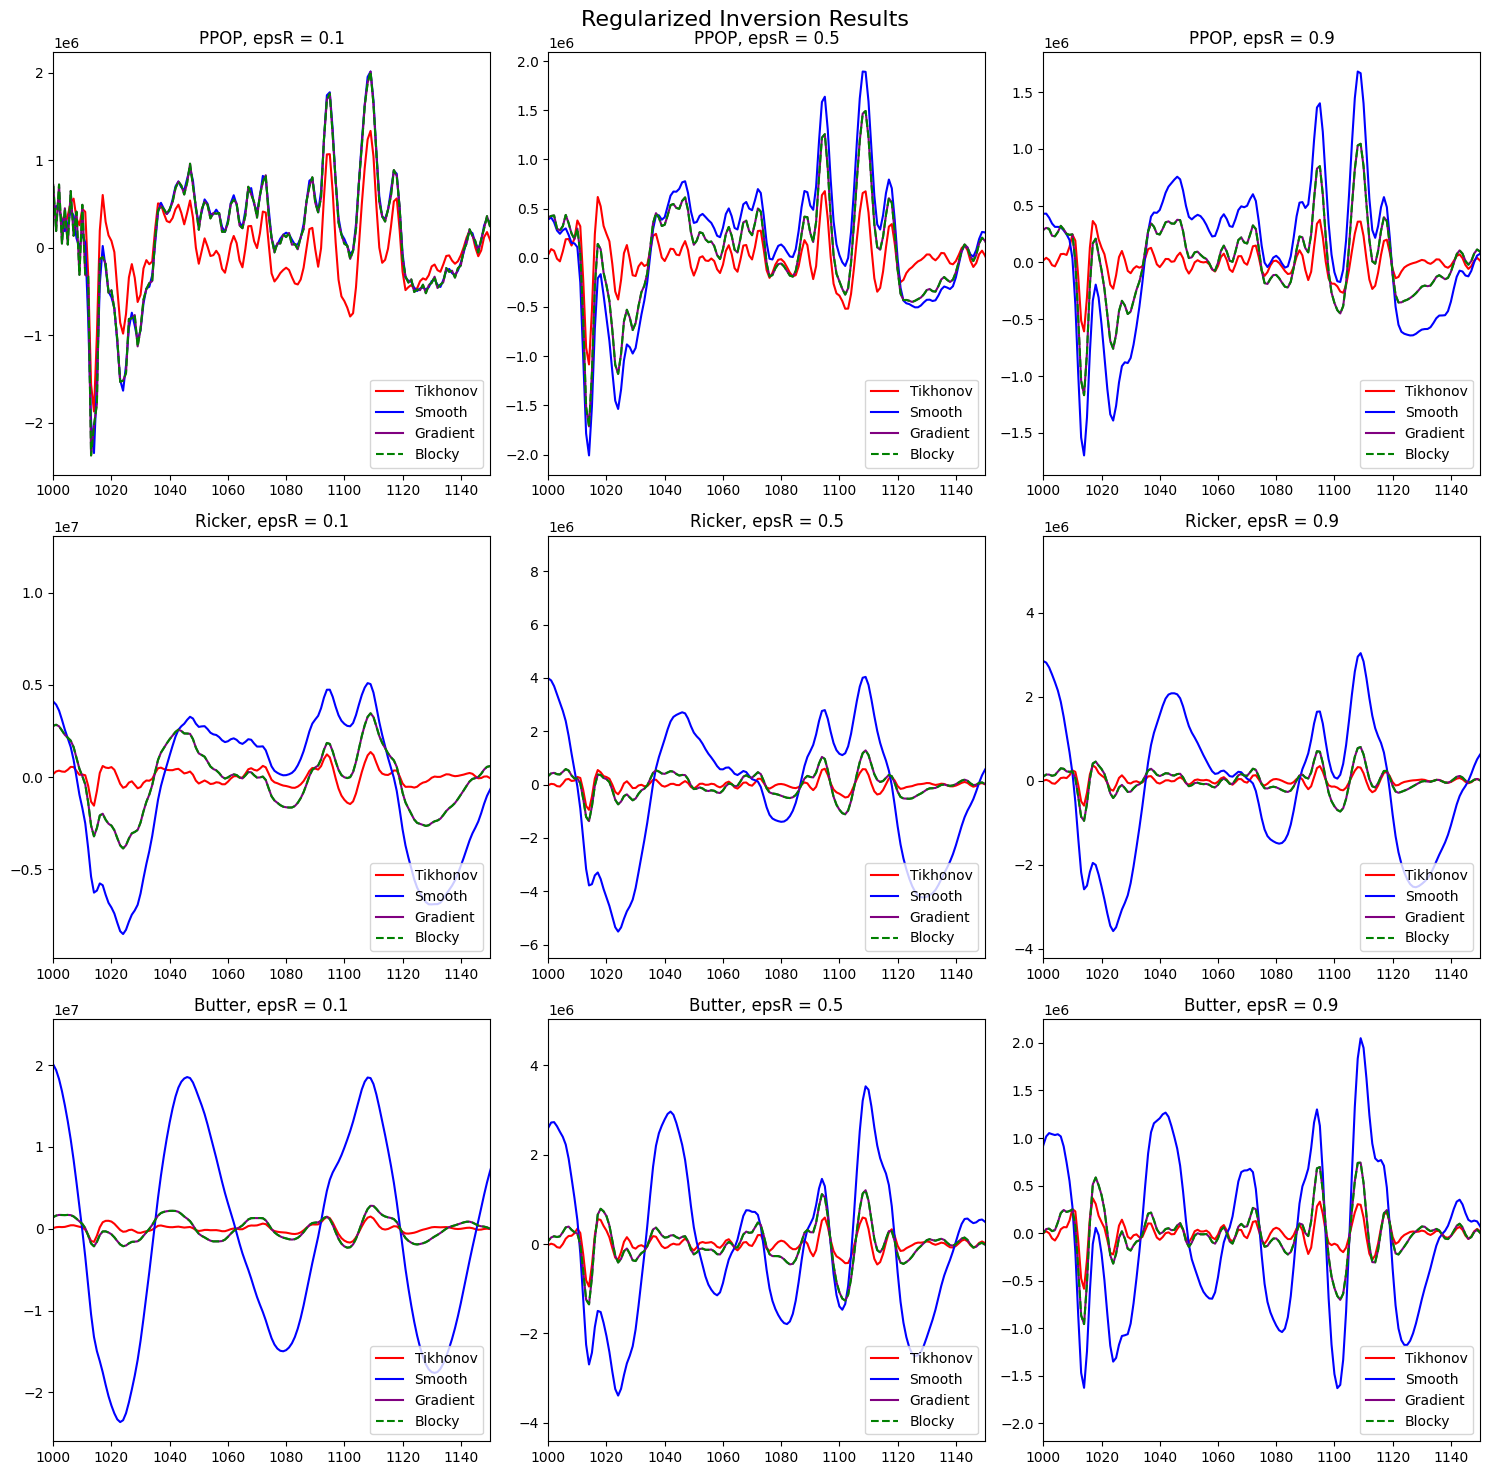

In [16]:
# Define the operators to iterate through
operators = [d_inv2_ppop, d_inv2_ppop_ricker, d_inv2_ppop_butter]
operator_names = ["PPOP", "Ricker", "Butter"]

regularizations = {
    "Tikhonov": pylops.Identity(nz),
    "Smooth": pylops.SecondDerivative(nz),
    "Blocky": pylops.FirstDerivative(nz),
    "Gradient": pylops.Gradient(nz)
}

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Regularized Inversion Results", fontsize=16)

for op_idx, (op, op_name) in enumerate(zip(operators, operator_names)):
    for eps_idx, eps in enumerate(epsRs_2):
        if eps_idx >= 3:
            break  
        results = {}
        
        for reg_name, reg in regularizations.items():
            results[reg_name] = pylops.regularized_inversion(
                Op=op,
                y=d[ILINE, XLINE, :],
                Regs=[reg],
                epsRs=[eps],
                x0=np.zeros(d[ILINE, XLINE, :].shape),
                engine="scipy",
                **dict(iter_lim=1000)
            )[0]
        
        row = op_idx
        col = eps_idx
        axs[row, col].plot(results["Tikhonov"], '-', color='red', label="Tikhonov")
        axs[row, col].plot(results["Smooth"], '-', color='blue', label="Smooth")
        axs[row, col].plot(results["Gradient"], '-', color='purple', label="Gradient")
        axs[row, col].plot(results["Blocky"], '--', color='green', label="Blocky")
        axs[row, col].set_xlim(1000, 1150)
        axs[row, col].legend(loc="lower right")
        axs[row, col].set_title(f'{op_name}, epsR = {eps:.1f}')

plt.tight_layout()
plt.savefig("./figures/regularized_inversion_wavelets_decon.png", dpi=400, bbox_inches="tight")
plt.show()


Post-stack seismic modelling is the process of constructing seismic post-stack data from a profile of an elastic parameter (Impedance or Velocity) of choice in time (or depth) domain. This can be easily achieved using the following forward model:

$$ d(t, \theta = 0) = w (t) \cdot \frac{d \ln m(t)}{dt} $$

where $m(t)$ is the elastic parameter profile and $w (t)$ is the time domain seismic wavelet. In compact form:

$$ \text{d} = \textbf{WDm} $$

In the special case of acoustic impedance ($m(t) = AI(t)$), the modelling operator can be used to create zero-offset data:

$$ d(t, \theta = 0) = \frac{1}{2} w (t) \cdot \frac{d \ln m(t)}{dt} $$

where the scaling factor $\frac{1}{2}$ can be easily included in the wavelet